# Определение возраста покупателей

Заказчиком проекта выступает сетевой супермаркет «Хлеб-Соль», который внедряет систему компьютерного зрения для обработки фотографий покупателей для определения возраста клиентов чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя.

Целью проекта является построение модели,способной по фотографии определять приблизительный возраст человека. Для его реализации предоставлен набор фотографий людей с указанием возраста:
-  папка со всеми изображениями (/final_files);
-  и CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Исследовательский анализ данных

Импортируем необходимые библиотеки

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Читаем файл "labels.csv ", сохраняем в переменной labels

In [88]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.head())
print('')
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Файл "labels" содержит 7591 объект, представленные двумя  колонками:
- "file_name" - поименованные растровые изображения в формате jpg (фотографии)
-  "real_age" - столбец с данными о возрасте (цельночисленный тип) изображенного на соответствующей фотографии 

<b> Исследуем данные о возрасте </b>

Строим "ящик с усами" по столбцу с данными о возрасте

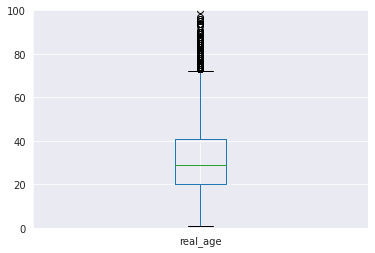

In [89]:
plt.ylim(0, 100)
ax=labels.boxplot(['real_age'])

Строим гистограмму распределения данных о возрасте

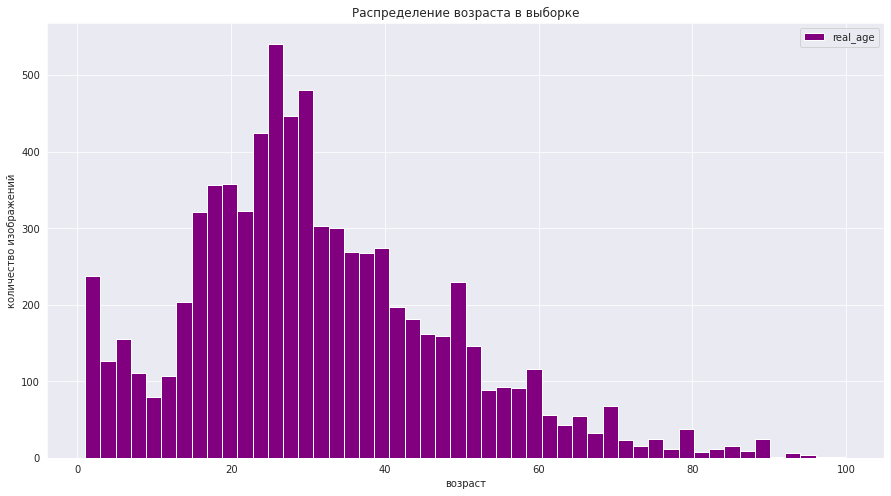

In [90]:
fig, ax = plt.subplots(1, 1)
labels['real_age'].hist(bins = 50, grid = True, legend = 'real_age', color='purple',figsize = (15,8))
ax.set_title("Распределение возраста в выборке")
ax.set_xlabel('возраст')
ax=ax.set_ylabel('количество изображений')  

In [91]:
labels['real_age'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  97, 100])

In [92]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Данные о возрасте изображенных на фотографиях представлены цельночисленным типом, находятся в диапазоне от 1 до 100 лет. В выборке нет фотографий, соответствующих возрасту 92, 98 и 99 лет.

График распределения возраста свидетельствует о том, что максимальное количество изображений содержат данные о возрасте 25-30 лет. За пределами межквартильного размаха находится возраст до 20 лет и после 41 года соответственно. 

Отсутствие изображений с возрастом 92, 98 и 99 лет может повлиять на то, что модель, обученная на таких данных, в реальности не сможет со 100% точностью идентифицировать этот возраст. Однако, в реальной жизни визуальной разницы лиц в возрасте от 90 до 100 лет нет, как и нет разницы в покупательском спросе этих людей. В этой связи отсутствие данных об указанной возрастной категории на качестве предсказаний модели практически не скажется.   

С помощью загрузчика данных ImageDataGenerator сформируем батчи с изображениями и вызовем функцию flow_from_dataframe 

In [93]:
datagen = ImageDataGenerator(rescale=1./255)
images = datagen.flow_from_dataframe(
        dataframe=labels,# исходный фрейм данных
        directory='/datasets/faces/final_files/',# расположение наших изображений относительно текущего рабочего каталога
        x_col='file_name',#Имя столбца в нашем фрейме данных, где хранятся имена файлов изображений
        y_col='real_age',#Имя столбца в нашем фрейме данных, где хранится целевой объект
        target_size=(150, 150),#До каких размеров мы хотели бы изменить размеры наших изображений
        batch_size=16,# размер пакета
        class_mode='raw',# решаем задачу регрессии
        seed=12345)

Found 7591 validated image filenames.


Загрузчик нашел 7591 подтвержденных имен файлов изображений, которые мы, в соответствии с условием проекта, распечатаем. 

Для визуализации изображений необходимо получить целевой признак, для этого используем функцию next, которой в качестве  аргумента передадим train_gen_flow. В результате получим признаки и целевой признак.

Методом shape узнаем размер получившихся данных

In [94]:
features, target = next(images)

print(features.shape)
print(target.shape)

(16, 150, 150, 3)
(16,)


Получились признаки — четырёхмерный тензор, в котором 16 изображений размером 150x150 с тремя цветовыми каналами.

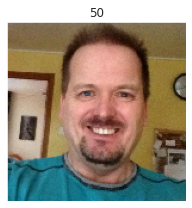

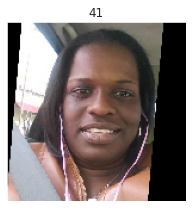

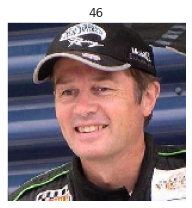

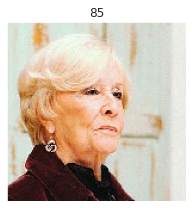

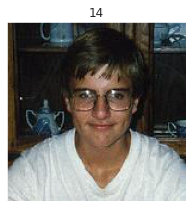

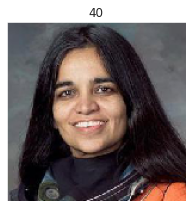

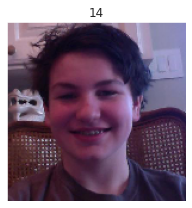

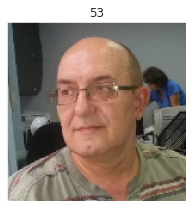

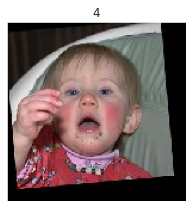

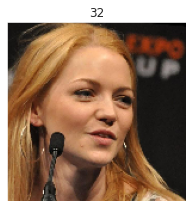

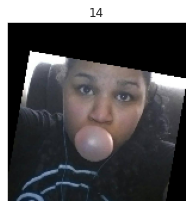

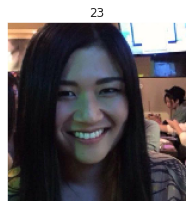

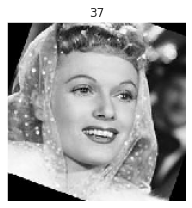

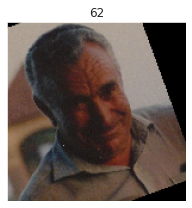

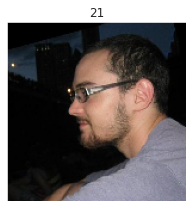

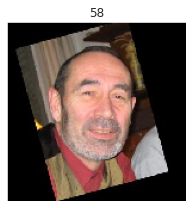

In [95]:
# выводим 16 изображений

for age, photo in zip(target[:16], features[:16]):
    plt.figure(figsize=(3,3))
    plt.title(age)
    plt.imshow(photo)
    
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


<b> Вывод:</b>
Мы изучили данные, представленные заказчиком для построения нейросети распознающей возраст покупателей - датасет с поименованными растровыми изображениями в формате jpg (фотографии) и данными о возрасте изображенного на соответствующей фотографии, а также сами изображения. 
    
Для чтения csv файла с размеченными изображениями применен метод pd.read_csv. Для визуализации изображений применен загрузчик данных ImageDataGenerator, с помощью которого сформированы батчи по 16 изображений, приведенных к формату 150х150 пикселей. Загрузчик распознал 7591 подтвержденное имя файлов изображений. Эти же методы мы используем для написания функций загрузки  данных обучающей и валидационной выборок для обучения нейросети.
    
Изучением датасета с данными о возрасте установлено, что имеются изображения людей в возрасте от 1 года до 100 лет.  Максимальное количество изображений содержат данные о возрасте 25-30 лет. Отсутствуют изображения с возрастом 92, 98 и 99 лет, в связи с чем модель, обученная на таких данных, в реальности не сможет со 100% точностью идентифицировать людей этого возраста. Вместе с тем, в реальной жизни визуальной разницы лиц в возрасте от 90 до 100 лет нет, как и нет разницы в покупательском спросе этих людей. В этой связи отсутствие данных об указанной возрастной категории на качестве предсказаний модели практически не скажется.  
    
Изучением фотографий установлено, что на них изображены лица людей с разного ракурса и, в том числе в различных жизненных ситуациях,закрывающих часть лица - в головных уборах, очках, наушниках, с едой, микрофоном и т.д. Все эти предметы в идеале могут негативно сказаться на качестве распознавания возраста. Но заказчику требуется определять возраст по снимкам людей возле кассовых аппаратов, где они могут находиться в таких же ситуациях и с такими же предметами, что и в базе данных. Значит можно считать наши данные для обучения корректными.     

## Обучение модели

Для обучения модели мы написали четыре функции:
-  load_train и load_test- загрузка обучающей и валидационной выборок, в которых использованы методы чтения csv файлов (pd.read_csv) и загрузчик  ImageDataGenerator() с функцией flow_from_dataframe(),при помощи которых проведена исследовательская часть данных;
-  create_model - создание модели нейронной сети на основе предобученной модели ResNet50;
-  train_model - функция запуска модели.

Переносим код обучения модели. 

```python
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Выводим результаты обучения модели.

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 66s - loss: 223.1476 - mae: 10.9432 - val_loss: 752.9758 - val_mae: 22.4629
Epoch 2/10
356/356 - 39s - loss: 87.8672 - mae: 7.1098 - val_loss: 144.8131 - val_mae: 9.2244
Epoch 3/10
356/356 - 39s - loss: 60.0072 - mae: 5.9338 - val_loss: 103.0449 - val_mae: 7.9898
Epoch 4/10
356/356 - 39s - loss: 42.6741 - mae: 4.9984 - val_loss: 101.9975 - val_mae: 7.7070
Epoch 5/10
356/356 - 39s - loss: 31.3572 - mae: 4.2647 - val_loss: 78.9037 - val_mae: 6.8914
Epoch 6/10
356/356 - 39s - loss: 23.1228 - mae: 3.6659 - val_loss: 79.3720 - val_mae: 6.6764
Epoch 7/10
356/356 - 39s - loss: 19.8658 - mae: 3.3602 - val_loss: 78.4466 - val_mae: 6.5244
Epoch 8/10
356/356 - 39s - loss: 16.1421 - mae: 3.0631 - val_loss: 70.5259 - val_mae: 6.2340
Epoch 9/10
356/356 - 38s - loss: 14.8411 - mae: 2.9084 - val_loss: 67.6399 - val_mae: 6.2680
Epoch 10/10
356/356 - 41s - loss: 13.3422 - mae: 2.7528 - val_loss: 74.3815 - val_mae: 6.2997
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 74.3815 - mae: 6.2997
Test MAE: 6.2997


```

Метрика качества MAE на тестовой выборке составила 6.2997, что соответствует условию проекта - не больше 8.

## Анализ обученной модели


<b> Вывод:</b> По заказу сетевого супермаркета «Хлеб-Соль» построена нейросеть, распознающая приблизительный возраст покупателей во время их фотофиксации у кассовых аппаратов. 

Для реализации данного проекта заказчиком предоставлен набор фотографий людей с разного ракурса (в том числе и закрывающего часть лица) с указанием возраста  от 1 года до 100 лет, в котором максимальное количество изображений содержат данные о возрасте 25-30 лет и отсутствуют изображения с возрастом 92, 98 и 99 лет. Вместе с тем, данные для обучения возможно считать корректными.

Для обучения нейросети написаны четыре функции:
-  load_train и load_test- загрузка обучающей и валидационной выборок, в которых использованы методы чтения csv файлов (pd.read_csv) и загрузчик ImageDataGenerator() с функцией flow_from_dataframe(),при помощи которых проведена исследовательская часть данных; размер признаков — четырёхмерный тензор, в котором 16 изображений размером 150x150 с тремя цветовыми каналами;
    
    
-  create_model - создание модели нейронной сети на основе предобученной модели ResNet50 с функцией активации 'relu', оптимизатором Adam со скоростью обучения lr=0.0001, функцией потерь избрана MSE, метрикой качества - MAE;
    
    
-  train_model - функция запуска модели с обучением за 10 эпох.
    
Модель обучена за 10 эпох. При этом метрика качества MAE снизилась с 22.5 на 1 эпохе до 6.3 - на 10 эпохе. Это хороший результат и соответствует условию проекта (не больше 8). Он означает, что погрешность предсказания возраста составляет 6 лет и 3,5 месяца. Для определения покупательского спроса это значительная разница только для детей (лиц, моложе 18 лет).
    
Вместе с тем, минимальная метрика качества MAE наблюдается на 8 эпохе обучения (6.2), что свидетельствует о том, что модель начала переобучаться и можно ограничиться 8 эпохами обучения. Однако, разница в 1,5 мес. не влияет на покупательский спрос (за исключением возраста до года, который у нас не представлен) в связи с чем такой параметр как количество эпох не меняется.
    
На основании проведенного исследования заказчику возможно предложить нейросеть, опеределяющую возраст покупателей на основе данных их фотофиксации возле кассовых аппаратов. Средняя погрешность в определении возраста - 6 с небольшим лет, что для подавляющего большинства покупателей в плане определения их покупательского спроса не является существенным.
   Для контроля добросовестности кассиров при продаже алкоголя возможности данной нейросети могут являться дополнительным инструментом, но не определяющим.    